In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

The data can be found here: https://www.kaggle.com/itssuru/loan-data

In [2]:
df = pd.read_csv('../data/loan_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [4]:
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


# Checking for missing values

In [5]:
df.isnull().sum()

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

In [6]:
df.purpose.unique()

array(['debt_consolidation', 'credit_card', 'all_other',
       'home_improvement', 'small_business', 'major_purchase',
       'educational'], dtype=object)

It appears there are no missing values

replacing the periods in column names with underscores for ease of use purposes.

In [7]:
df.columns = [x.replace('.','_') for x in df.columns]
df.columns

Index(['credit_policy', 'purpose', 'int_rate', 'installment', 'log_annual_inc',
       'dti', 'fico', 'days_with_cr_line', 'revol_bal', 'revol_util',
       'inq_last_6mths', 'delinq_2yrs', 'pub_rec', 'not_fully_paid'],
      dtype='object')

To make it easier on myself to interpret plots, I'm creating a fully_paid column.

In [8]:
df['fully_paid'] = 1 - df.not_fully_paid
df.drop('not_fully_paid',axis=1,inplace=True)

In [9]:
df.fully_paid.value_counts()

1    8045
0    1533
Name: fully_paid, dtype: int64

# Splitting the data

The original dataframe, or a subset of it, dividing it into equal groups, will be used for exploratory data analysis.  For removing extreme outliers only what will be used as the training set in model development will be used.

In [10]:
original = df.copy()
df, df_test = train_test_split(df, random_state=675, test_size=0.2)

In [11]:
paid=original[original.fully_paid==1]
not_paid =original[original.fully_paid==0]
paid_subsample = paid.sample(n=1000, random_state=675)
not_paid_subsample = not_paid.sample(n=1000, random_state=675)
df_subsample = pd.concat([paid_subsample,not_paid_subsample])

# Exploring the features


## Credit policy

1 if the customer meets the credit underwriting policy of lending club, 0 if they do not.

<AxesSubplot:xlabel='credit_policy', ylabel='count'>

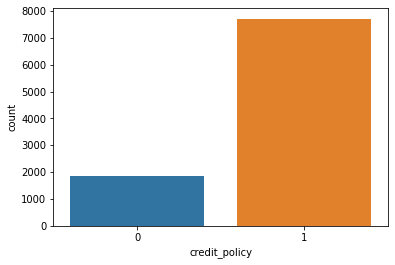

In [12]:
sns.countplot(x = 'credit_policy', data = original)

More customers meet the credit policy than not.

Now compairing credit policy counts with fully paid counts...

<AxesSubplot:xlabel='credit_policy', ylabel='count'>

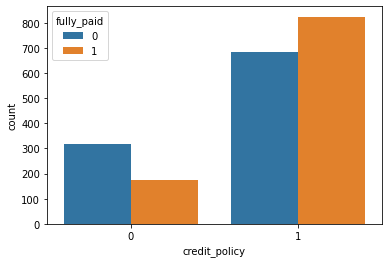

In [13]:
sns.countplot(x = 'credit_policy', hue = 'fully_paid', data = df_subsample)


For those that do not meet the credit policy there are more not fully paid than fully paid.  The reverse is true for those that meet the credit policy.

## Purpose

In [14]:
original.purpose.unique()

array(['debt_consolidation', 'credit_card', 'all_other',
       'home_improvement', 'small_business', 'major_purchase',
       'educational'], dtype=object)

When doing modeling this will need to be one hot encoded

<AxesSubplot:xlabel='purpose', ylabel='count'>

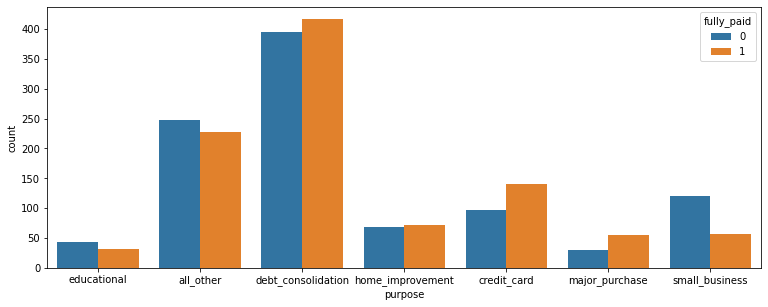

In [15]:
fig, ax = plt.subplots(figsize=(12.8,4.8))
sns.countplot(x='purpose',hue='fully_paid',data=df_subsample)

For a major purchase, debt consolidation, and credit card there are more fully paid than not.

## interest rate

The interest rate of the loan

<AxesSubplot:>

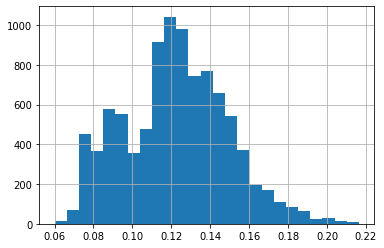

In [16]:
original.int_rate.hist(bins=25)

In [17]:
original.int_rate.describe()

count    9578.000000
mean        0.122640
std         0.026847
min         0.060000
25%         0.103900
50%         0.122100
75%         0.140700
max         0.216400
Name: int_rate, dtype: float64

The interest raid paid has a skewed distribution with some paying large interest rates.  The mean interest rate is 12%.  Looking at the interest rate distributions for paid and unpaid loans...

<AxesSubplot:xlabel='fully_paid', ylabel='int_rate'>

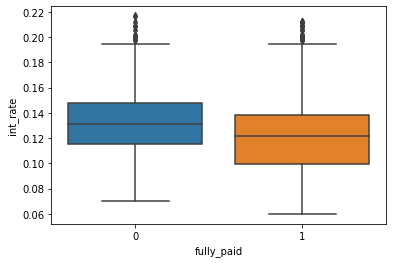

In [18]:
sns.boxplot(x='fully_paid',y='int_rate',data=original)

As you can see the interest rate is slightly higher for those not fully paid.  

### Detecting outliers

*note to self: if you do find persistent outliers, you will need to use a validation set*

As the distribution is skewed, I will do 2 iqr to detect extreme outliers


In [19]:
# checking outliers in the distribution
outlier_counts = {}
stats = df.int_rate.describe()
q1 = stats['25%']
q3 = stats['75%']
iqr = 2*(q3-q1)
outliers = list(df[df.int_rate > q3 + iqr].index)
outliers

[9566, 9549]

In [20]:
for o in outliers:
    outlier_counts[o] = outlier_counts.get(o,0)+1


## installment

the monthly installments owed by the borrower

<AxesSubplot:>

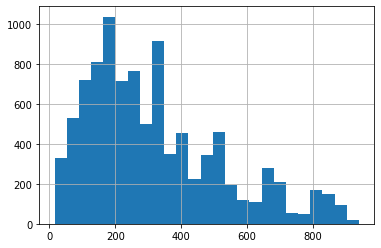

In [21]:
original.installment.hist(bins=25)

In [21]:
original.installment.describe()

count    9578.000000
mean      319.089413
std       207.071301
min        15.670000
25%       163.770000
50%       268.950000
75%       432.762500
max       940.140000
Name: installment, dtype: float64

<AxesSubplot:xlabel='fully_paid', ylabel='installment'>

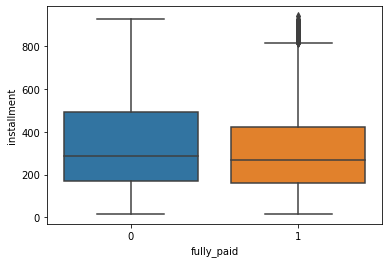

In [22]:
sns.boxplot(x='fully_paid',y='installment',data=original)

There is only a slight difference

### Detecting outliers

In [23]:
stats = df.installment.describe()
q1 = stats['25%']
q3 = stats['75%']
iqr = 2*(q3-q1)
outliers = list(df[df.installment > q3 + iqr].index)
outliers

[]

Even though there is skew, no outliers are apparent in the training set.


## Log annual income

The log of the annual income of the borrower.  

<AxesSubplot:>

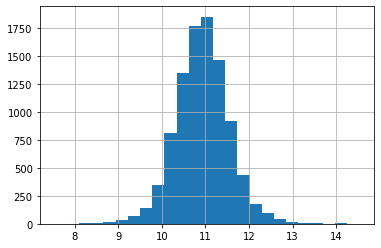

In [24]:
original.log_annual_inc.hist(bins=25)

Log annual income seems relatively normal.

<AxesSubplot:xlabel='fully_paid', ylabel='log_annual_inc'>

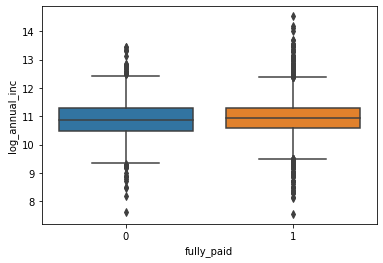

In [25]:
sns.boxplot(x='fully_paid',y='log_annual_inc',data=original)

There doesn't appear to be much difference between the income distributions of those who have fully faid and those who have not.

### Detecting outliers

In [27]:
stats = df.log_annual_inc.describe()
q1 = stats['25%']
q3 = stats['75%']
iqr = 4*(q3-q1)
outliers = list(df[(df.log_annual_inc > q3 + iqr)|(df.log_annual_inc < q1 -iqr)].index)
outliers

# 4 iqr?

#mu = df.log_annual_inc.mean()
#std = df.log_annual_inc.std()
#df[(df.log_annual_inc < mu - 3*std)|(df.log_annual_inc > mu + 3*std)].index

[7897, 653, 7822]

In [28]:
for o in outliers:
    outlier_counts[o] = outlier_counts.get(o,0)+1

## dti

The debt to income ratio of the borrower

<AxesSubplot:>

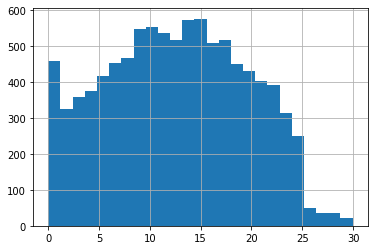

In [29]:
original.dti.hist(bins=25)

Definitely not normal.  There appears to be two distributions, those without debt and those with debt.

In [30]:
original[original.dti==0].shape[0]

89

<AxesSubplot:>

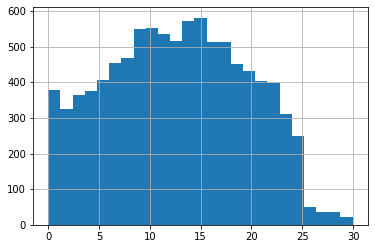

In [35]:
no_debt_sample = df_subsample[df_subsample.dti==0]
debt_original = original[original.dti!=0]
debt_original.dti.hist(bins=25)

Looking at boxplots for those with debt

<AxesSubplot:xlabel='fully_paid', ylabel='dti'>

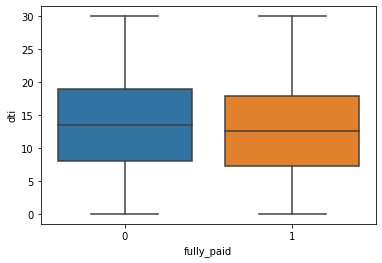

In [36]:
sns.boxplot(x='fully_paid',y='dti',data=debt_original)

Only a slight difference between the two. No outliers are apparent.

Looking at counts for those with no debt

<AxesSubplot:xlabel='fully_paid', ylabel='count'>

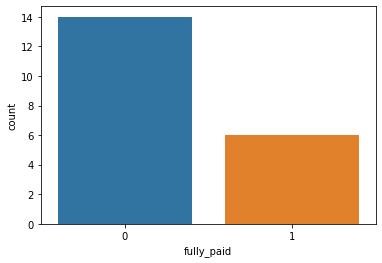

In [37]:
sns.countplot(x = 'fully_paid', data = no_debt_sample)

Odd, for those without debt, more have not fully paid.

### Fico score

<AxesSubplot:>

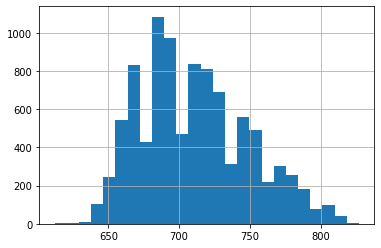

In [38]:
original.fico.hist(bins=25)

<AxesSubplot:xlabel='fully_paid', ylabel='fico'>

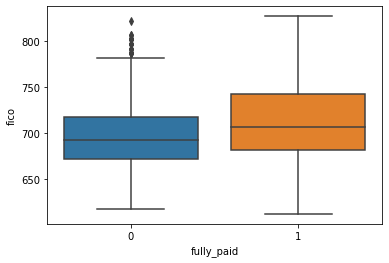

In [39]:
sns.boxplot(x='fully_paid',y='fico',data=original)

Fico score on average is slightly higher for those who have paid.

### Detecting outliers

In [40]:
stats = df.fico.describe()
q1 = stats['25%']
q3 = stats['75%']
iqr = 2*(q3-q1)
outliers = list(df[(df.fico < q1 - iqr)|(df.fico > q3 + iqr)].index)
outliers

[]

Using 2 iqr there appear to be no outliers

## days_with_cr_line
The number of days a borrower has a credit line

<AxesSubplot:>

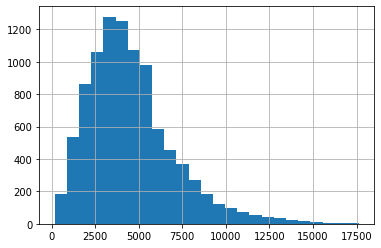

In [41]:
original.days_with_cr_line.hist(bins=25)

The distribution is not normal.  It appears more like Poisson

<AxesSubplot:xlabel='fully_paid', ylabel='days_with_cr_line'>

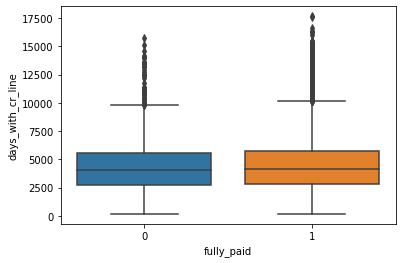

In [42]:
sns.boxplot(x='fully_paid',y='days_with_cr_line',data=original)

There doesn't appear to be much difference between average days with credit line for those whom paid and those who didnt.

## revol_bal

The borrowers revolving balance at the end of the credit card cycle.

<AxesSubplot:>

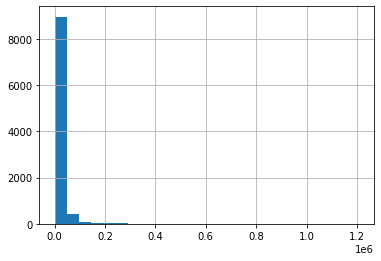

In [43]:
original.revol_bal.hist(bins=25)

There definitely appear to be outliers

### Outlier detection

<AxesSubplot:>

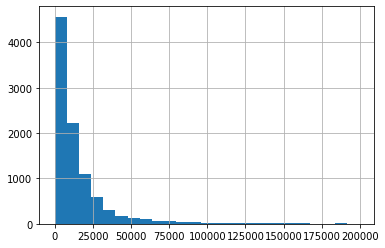

In [48]:
original[original.revol_bal < 200000].revol_bal.hist(bins=25)

In [55]:
outliers = list(df[df.revol_bal > 400000].index)
outliers

[7987, 9042, 8034, 9149]

In [56]:
for o in outliers:
    outlier_counts[o] = outlier_counts.get(o,0)+1

In [57]:
outlier_counts

{9566: 1,
 9549: 1,
 7897: 1,
 653: 1,
 7822: 1,
 7987: 1,
 9042: 1,
 8034: 1,
 9149: 1}